In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/semantic-segmentation-model-weights/model_weights.h5
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/classes.json
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_002.jpg
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_006.jpg
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_005.jpg
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_003.jpg
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_004.jpg
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_007.jpg
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_009.jpg
/kaggle/input/sem

In [11]:
!pip install patchify

In [12]:
import os
import cv2
from PIL import Image 
import numpy as np 
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
import random

In [13]:
minmaxscaler = MinMaxScaler()

In [14]:
dataset_root_folder = '/kaggle/input/semantic-segmentation-of-aerial-imagery/'

In [15]:
# Semantic segmentation dataset 
dataset_name = "Semantic segmentation dataset"

In [16]:
image_patch_size = 256

Tile & Mask Processing

In [17]:
image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
     image_extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        #print("{} --- {} - {}".format(image.shape, size_x, size_y))
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        #print("({},  {})".format(image.size[0],image.size[1]))
        image = np.array(image)
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)



In [18]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [19]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


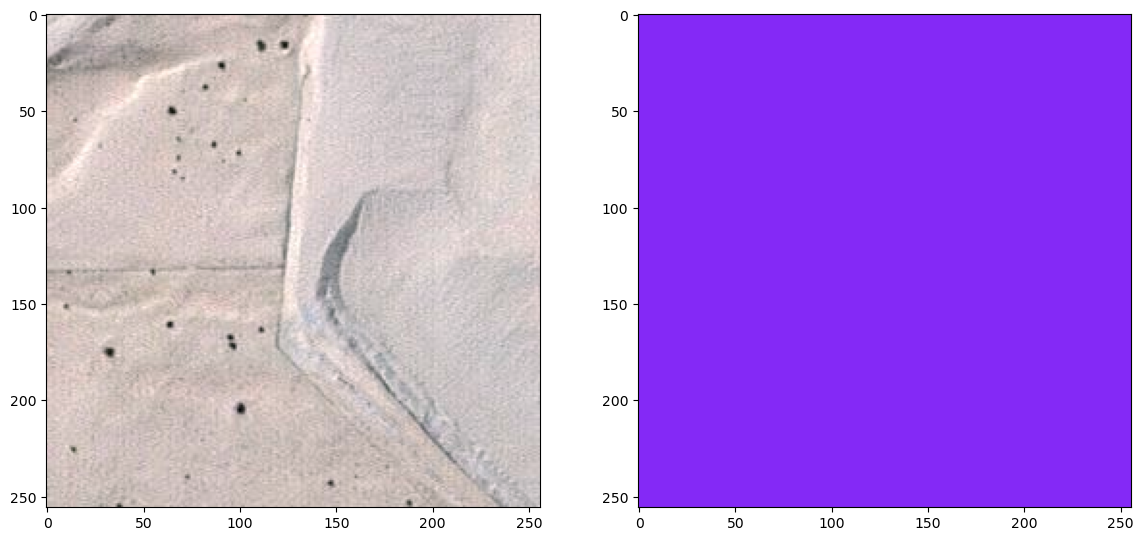

In [20]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])
     

In [21]:
# Building Class

class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

# Land Class

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

# Road Class

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

# Veg Class

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

# Water Class

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

# Unlabeled Class

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [22]:
label = individual_patched_mask

In [23]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

In [24]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [25]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [26]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [27]:
print("Total unique labels based on masks: ",format(np.unique(labels)))

Total unique labels based on masks:  [0 1 2 3 4 5]


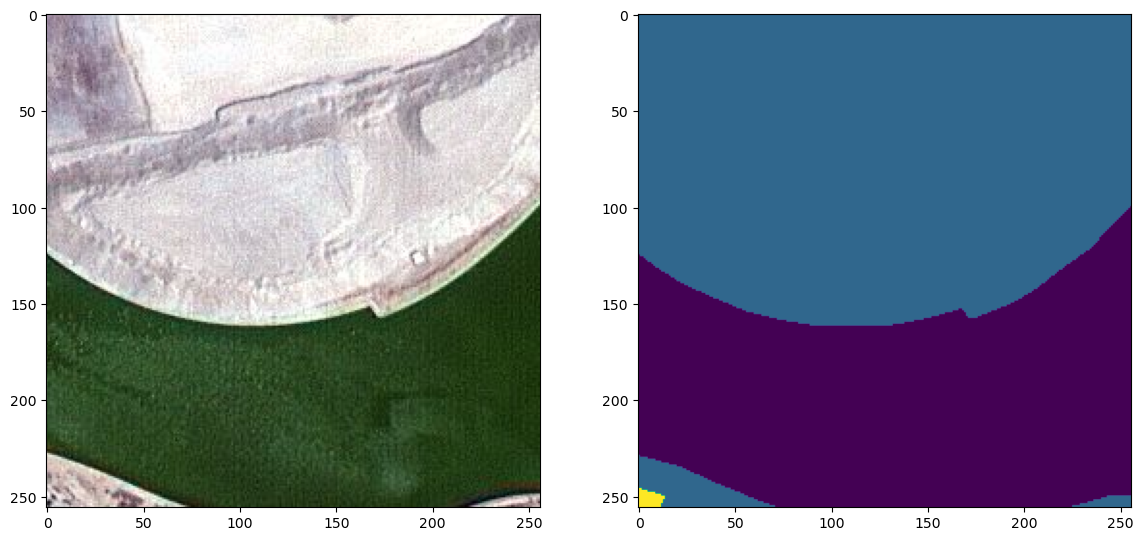

In [28]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
#plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

In [29]:
total_classes = len(np.unique(labels))

In [30]:
total_classes

6

In [31]:
from tensorflow.keras.utils import to_categorical

In [32]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [33]:
master_trianing_dataset = image_dataset

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [35]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [36]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [37]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


### U-Net segmentation-models

In [38]:
!pip install -U segmentation-models

In [39]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [40]:
from keras import backend as K

In [41]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [42]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model
     

In [43]:
metrics = ["accuracy", jaccard_coef]

In [44]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [45]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes, 
                          image_height=image_height, 
                          image_width=image_width, 
                          image_channels=image_channels)

In [46]:
model = get_deep_learning_model()

In [47]:
# model.get_config()

## Generating Loss Function
- dice loss > Focal Loss > Total Loss
- Total Loss = (Dice loss + (1*Focal Loss))

In [48]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

In [49]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [50]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [51]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)

In [52]:
focal_loss = sm.losses.CategoricalFocalLoss()

In [53]:
total_loss = dice_loss + (1 * focal_loss)

### Model compilation

In [54]:
import tensorflow as tf

In [55]:
tf.keras.backend.clear_session()

In [56]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [48]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

### Visualize Model with Keras

In [49]:
from keras.utils.vis_utils import plot_model

In [50]:
# plot_model(model, to_file="satellite_model_plot.png", show_shapes=True, show_layer_names=True)

### Model . Fit

In [59]:
import keras
from IPython.display import clear_output

%matplotlib inline

In [60]:
class PlotLoss(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []

    self.jaccard_coef = []
    self.val_jaccard_coef = []

    self.fig = plt.figure()
    self.logs = []

  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(logs)
    self.x.append(self.i)
    # self.losses.append(logs.get('loss'))
    # self.val_losses.append(logs.get('val_loss'))

    self.jaccard_coef.append(logs.get('jaccard_coef'))
    self.val_jaccard_coef.append(logs.get('val_jaccard_coef'))

    self.i += 1
    
    clear_output(wait=True)
    # plt.plot(self.x, self.losses, label="loss")
    # plt.plot(self.x, self.val_losses, label="val_loss")

    plt.plot(self.x, self.jaccard_coef, label="jaccard_coef")
    plt.plot(self.x, self.val_jaccard_coef, label="val_jaccard_coef")

    plt.legend()
    plt.show();

plot_loss = PlotLoss()

In [61]:
class PlotLossEx(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []

    self.losses = []
    self.val_losses = []

    self.jaccard_coef = []
    self.val_jaccard_coef = []

    self.fig = plt.figure()
    self.logs = []

  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(logs)
    self.x.append(self.i)

    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    self.jaccard_coef.append(logs.get('jaccard_coef'))
    self.val_jaccard_coef.append(logs.get('val_jaccard_coef'))

    self.i += 1

    plt.figure(figsize=(14,8))
    f, (graph1, graph2) = plt.subplots(1,2, sharex=True)
    
    clear_output(wait=True)

    graph1.set_yscale('log')
    graph1.plot(self.x, self.losses, label="loss")
    graph1.plot(self.x, self.val_losses, label="val_loss")
    graph1.legend()

    graph2.set_yscale('log')
    graph2.plot(self.x, self.jaccard_coef, label="jaccard_coef")
    graph2.plot(self.x, self.val_jaccard_coef, label="val_jaccard_coef")
    graph2.legend()

    plt.show();

plot_loss = PlotLossEx()

In [54]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [55]:
import torch

In [56]:
# Initialize the device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [57]:
# model.load_weights('model_weights.h5')

In [58]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the callbacks
checkpoint = ModelCheckpoint('model_weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

# Train the model
model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=50,
                          validation_data=(X_test, y_test),
                          callbacks=[checkpoint, early_stop],
                          shuffle=False)


Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 0.9354 - accuracy: 0.7922 - jaccard_coef: 0.5868
Epoch 1: val_loss improved from inf to 0.95711, saving model to model_weights.h5
51/51 [==============================] - 266s 5s/step - loss: 0.9354 - accuracy: 0.7922 - jaccard_coef: 0.5868 - val_loss: 0.9571 - val_accuracy: 0.7521 - val_jaccard_coef: 0.5538
Epoch 2/50
51/51 [==============================] - ETA: 0s - loss: 0.9310 - accuracy: 0.8063 - jaccard_coef: 0.6107
Epoch 2: val_loss did not improve from 0.95711
51/51 [==============================] - 256s 5s/step - loss: 0.9310 - accuracy: 0.8063 - jaccard_coef: 0.6107 - val_loss: 0.9675 - val_accuracy: 0.7357 - val_jaccard_coef: 0.5488
Epoch 3/50
51/51 [==============================] - ETA: 0s - loss: 0.9310 - accuracy: 0.8068 - jaccard_coef: 0.6112
Epoch 3: val_loss improved from 0.95711 to 0.95120, saving model to model_weights.h5
51/51 [==============================] - 253s 5s/step - loss: 0.9310 - accur

In [60]:
history_a = model_history

In [62]:
# history_a.history
df_result = pd.DataFrame(history_a.history)
df_result

,loss,accuracy,jaccard_coef,val_loss,val_accuracy,val_jaccard_coef
0,0.935369,0.792169,0.586806,0.957106,0.752061,0.553833
1,0.931049,0.806279,0.610738,0.967467,0.735705,0.548788
2,0.930972,0.806825,0.611245,0.951199,0.762334,0.575605
3,0.927308,0.816887,0.629354,0.959251,0.755243,0.573589
4,0.926734,0.816927,0.629813,0.956545,0.762488,0.585979
5,0.924301,0.824374,0.641488,0.950547,0.773739,0.601020
6,0.922023,0.830098,0.652179,0.942242,0.789441,0.618224
7,0.920077,0.834548,0.660584,0.944550,0.786414,0.617232
8,0.922348,0.828662,0.649608,0.935751,0.800267,0.629446
9,0.918510,0.837906,0.667988,0.934634,0.802490,0.639550


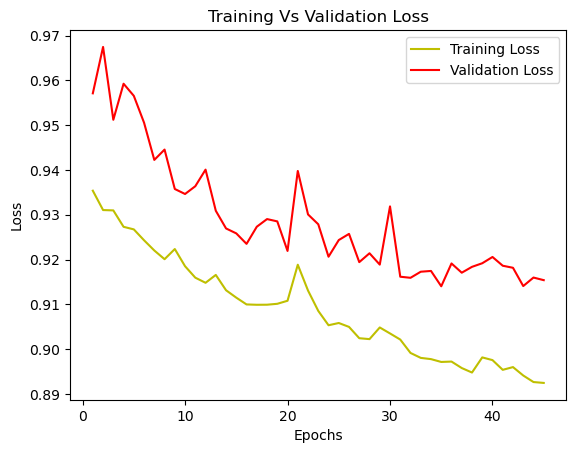

In [63]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

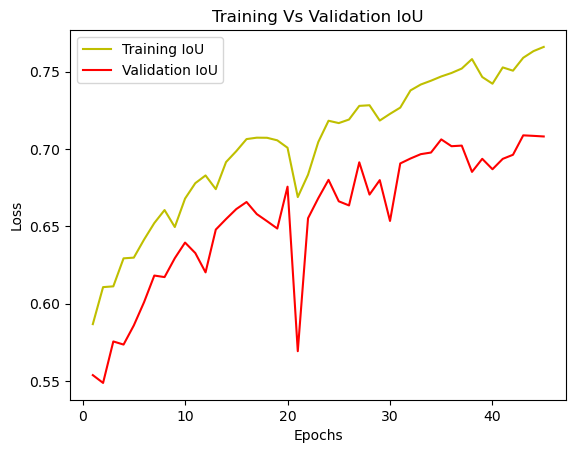

In [64]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [65]:
model_history.params

{'verbose': 1, 'epochs': 50, 'steps': 51}

In [66]:
y_pred = model.predict(X_test)

5/5 [==============================] - 10s 2s/step


In [67]:
len(y_pred)

142

In [68]:
y_pred

array([[[[7.24815903e-03, 6.02149248e-01, 8.08787793e-02,
          2.76536703e-01, 3.22817601e-02, 9.05306893e-04],
         [1.80695008e-03, 3.90314341e-01, 6.06825687e-02,
          5.01155734e-01, 4.58442383e-02, 1.96159686e-04],
         [1.91033166e-03, 3.50206017e-01, 3.51075754e-02,
          5.45575261e-01, 6.69666380e-02, 2.34083840e-04],
         ...,
         [2.02097334e-02, 3.78278911e-01, 4.64035034e-01,
          4.93942350e-02, 8.72901455e-02, 7.91894447e-04],
         [1.97046362e-02, 4.35597628e-01, 3.96200776e-01,
          7.21730292e-02, 7.55918920e-02, 7.32009008e-04],
         [4.93215472e-02, 4.05302525e-01, 3.23543996e-01,
          9.66322869e-02, 1.20132931e-01, 5.06671146e-03]],

        [[2.08960730e-03, 5.70339024e-01, 6.99109584e-02,
          2.97018915e-01, 6.04884997e-02, 1.52985915e-04],
         [2.17535664e-04, 4.55279350e-01, 3.95624936e-02,
          4.52401370e-01, 5.25297448e-02, 9.66457264e-06],
         [2.79433705e-04, 3.78572106e-01, 2.1061

In [69]:
y_pred_argmax = np.argmax(y_pred, axis=3)

In [70]:
len(y_pred_argmax)

142

In [71]:
y_pred_argmax

array([[[1, 3, 3, ..., 2, 1, 1],
        [1, 1, 3, ..., 2, 2, 1],
        [1, 1, 3, ..., 2, 2, 2],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [4, 4, 4, ..., 2, 2, 1],
        [4, 4, 4, ..., 2, 2, 1],
        [4, 4, 4, ..., 2, 1, 1]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4],
        [1, 1, 1, ..., 4, 4, 4]],

       [[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 

In [72]:
y_test_argmax = np.argmax(y_test, axis=3)

In [73]:
y_test_argmax

array([[[3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 1, ..., 0, 0, 0]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

### Comparing prediction results
- using test images using mask images and predicted result images..

In [1]:
import random

In [ ]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

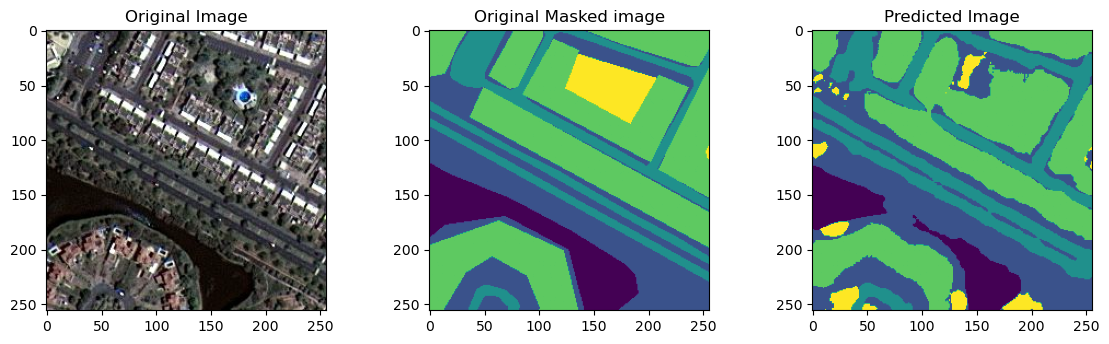

In [76]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)

In [78]:
model.save("satellite_segmentation_full.h5")

In [ ]:
!ls -lah

## Satellite_segmentation_Prediction-Base

In [64]:
!pip install -U segmentation-models

In [3]:
!pip install gdown

In [67]:
import os
import cv2
from PIL import Image 
import numpy as np 
import segmentation_models as sm
from matplotlib import pyplot as plt
import random

In [68]:
from keras import backend as K
from keras.models import load_model

In [69]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [70]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [66]:
!gdown --id 1sf7s99IvoLW6xV7f8nymJqyambf79RYB

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:130: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1sf7s99IvoLW6xV7f8nymJqyambf79RYB
To: /kaggle/working/satellite_segmentation_full.h5
100%|██████████████████████████████████████| 23.5M/23.5M [00:00<00:00, 26.8MB/s]


In [71]:
satellite_model = load_model('/kaggle/working/satellite_segmentation_full.h5',
                         custom_objects=({'dice_loss_plus_1focal_loss': total_loss, 
                                          'jaccard_coef': jaccard_coef}))

In [ ]:
#satellite_model.get_config()

In [5]:
# get test iamge from drive
# !gdown --id 1nGR6EcuExHGI3obMWlxDO0w0qr9hHBra

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:130: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1nGR6EcuExHGI3obMWlxDO0w0qr9hHBra
To: /kaggle/working/fc-img1.png
100%|███████████████████████████████████████| 3.82M/3.82M [00:00<00:00, 145MB/s]


In [72]:
from PIL import Image
import numpy as np

# Load the image and resize it to 256x256
image = Image.open('/kaggle/working/image you want to test with')
image = image.resize((256, 256))

# Convert the image to a numpy array and remove the alpha channel
image = np.array(image)
image = image[:, :, :3]

# Add a batch dimension to the array
image = np.expand_dims(image, 0)
print(image.shape)

In [73]:
prediction = satellite_model.predict(image)

ValueError: in user code:

    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/input_spec.py", line 296, in assert_input_compatibility
        f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(None, 256, 256, 4)


In [ ]:
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(Image.open('image you want to test with'))
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)

## other Some Predictions

In [ ]:
vmin = 0
vmax = 2

for i in range(5):
    
    image_number = random.randint(0, X_test.shape[0])
    
    plt.figure(figsize=(24, 6))
    
    plt.subplot(141)
    plt.title('Image')
    plt.imshow(X_test[image_number])
    
    plt.subplot(142)
    plt.title('True')
    true = y_test[image_number].argmax(axis=2)
    plt.imshow(true, vmin = vmin, vmax = vmax)
    
    plt.subplot(143)
    plt.title('Prediction')
    prediction = model.predict(np.expand_dims(X_test[image_number], 0))[0].argmax(axis=2) + 1 # convert to 0-5 classes
    plt.imshow(prediction, vmin = vmin, vmax = vmax)
    
    plt.subplot(144)
    plt.title('Error')
    error = (true != prediction) & (true != 0)
    error = error.astype(int)
    plt.imshow(error, cmap='gray')
    
    plt.show()